# 1.Perkenalan

Nama : Ferdiansyah Ersatiyo

FTDS RMT 020

## Objective

Sebagai seseorang data scientist yang bekerja dari indonesia kita diminta untuk membuat model untuk menentukan gaji bagi seorang data science dari seluruh dunia. gaji akan dihitung per tahun dalam USD. Kita akan menggunakan algoritma regresi untuk menentukan gaji yang tepat bagi seorang data science agar perusahaan tidak melakukan underpaid maupun overpaid yang akan merugikan data scientist dan juga perusahaan. Kita juga akan melihat apakah asal negara mempengaruhi gaji yang akan diterima oleh seorang data scientist

## Data Source

data yang digunakan adalah data scientist salary 2023 yang diambil dari kaggle pada link [berikut](https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023)

# 2.Import Library

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib as jb
import pickle as pkl


from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# 3.Loading Data

In [55]:
df = pd.read_csv('/content/DataScienceSalaries.csv')
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [56]:
dup = df.copy()

# 4.EDA

There are 4 categorical values in the column "experience_level", such as:
- EN, which is Entry-level.
- MI, which is Mid-level.
- SE, which is Senior-level.
- EX, which is Executive-level.

There are 4 categorical values in the column "employment_type", such as:

- FT, which is Full-time.
- PT, which is Part-time.
- CT, which is Contractual.
- FL, which is Freelancer.

There are 3 categorical values in the column "remote_ratio", such as:

- 100, which is Remotely.
- 0, which is On-site.
- 50, which is Hybrid.

In [58]:
dup.nunique()

work_year                4
experience_level         4
employment_type          4
job_title               93
salary                 815
salary_currency         20
salary_in_usd         1035
employee_residence      78
remote_ratio             3
company_location        72
company_size             3
dtype: int64

In [59]:
dup.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


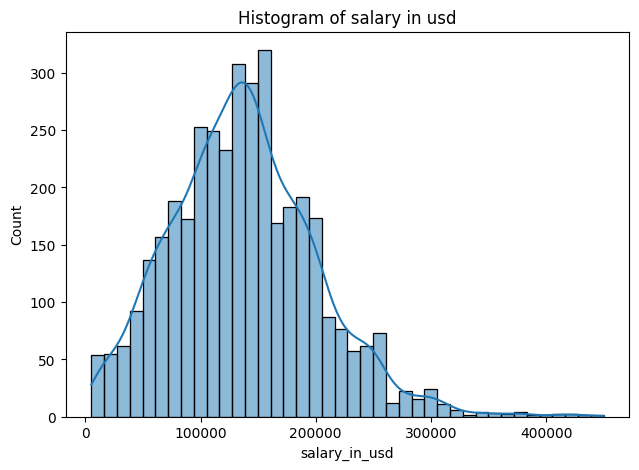

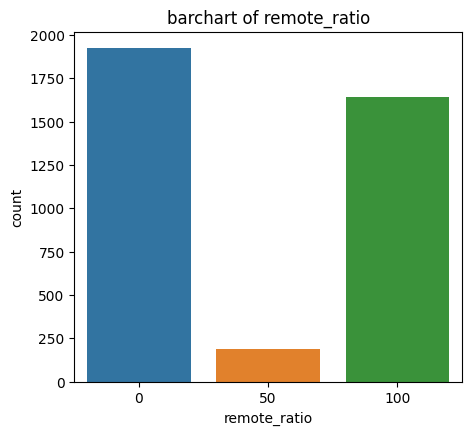

In [60]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.histplot(dup['salary_in_usd'], kde=True, bins=40)
plt.title('Histogram of salary in usd')

plt.figure(figsize=(5,10))
plt.subplot(2,1,2)
sns.countplot(data=dup, x='remote_ratio')
plt.title('barchart of remote_ratio')
plt.show()

## Experience Level

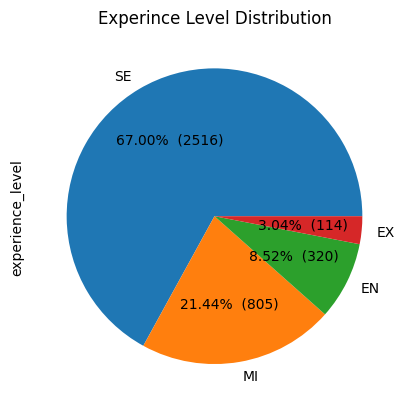

In [61]:
exp = dup.experience_level.value_counts()

# Explanation SE : Senior. EN : Entry level. EX : Executive level. MI : Mid/Intermediate level.

#plot exp
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

exp.plot.pie(autopct=make_autopct(exp))
plt.title('Experince Level Distribution')
plt.show()

Kita dapat melihat bahwa dari data ini banyak orang yang bekerja pada level senior kemudian middle kemudian entry level dan yang paling sedikit adalah pada jabatan excecutive.

In [62]:
dup.groupby(['experience_level','employment_type'])['employment_type'].count()

# Explanation FT : FULLTIME. PT :PART TIME. CT : CONTRACT. FL : FREELANCE.

experience_level  employment_type
EN                CT                    2
                  FL                    2
                  FT                  302
                  PT                   14
EX                CT                    1
                  FT                  113
MI                CT                    5
                  FL                    5
                  FT                  792
                  PT                    3
SE                CT                    2
                  FL                    3
                  FT                 2511
Name: employment_type, dtype: int64

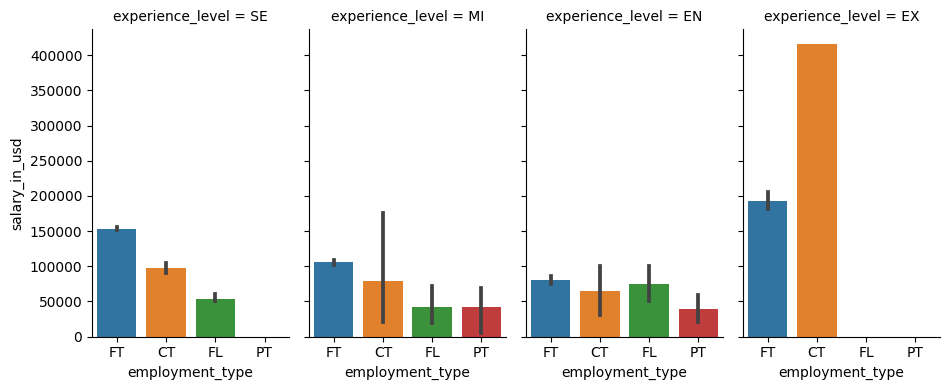

In [63]:
sns.catplot(
    data=dup, x="employment_type", y="salary_in_usd", col="experience_level",
    kind="bar", height=4, aspect=.6,)

dilihat dari gaji dalam dollar pada posisi FULLTIME(FT) memiliki gaji yang lebih besar pada semua experience level dibandingkan dengan tipe kerja lainnya. Namun pada level excecutive gaji terbesar dimiliki oleh karyawan kontrak. hal ini menandakan pada level excecutive kemungkinan yang dikontrak adalah orang yang sudah expert pada bidang data dan dibayar tinggi sesuai kemampuannya.

## Highest Paycheck

In [64]:
# melihat negara dengan gaji tertinggi
location_payrate = dup.groupby(['company_location'])['salary_in_usd'].sum()

lar = location_payrate.nlargest(5)
print(lar)


#melihat pekerjaan dengan gaji tertinggi
work_rate = dup.groupby(['job_title'])['salary_in_usd'].mean()

work = work_rate.nlargest(5)
print(' ')
print(work)

company_location
US    461538909
GB     14945089
CA     11476839
DE      4944173
ES      4441057
Name: salary_in_usd, dtype: int64
 
job_title
Data Science Tech Lead      375000.000
Cloud Data Architect        250000.000
Data Lead                   212500.000
Data Analytics Lead         211254.500
Principal Data Scientist    198171.125
Name: salary_in_usd, dtype: float64


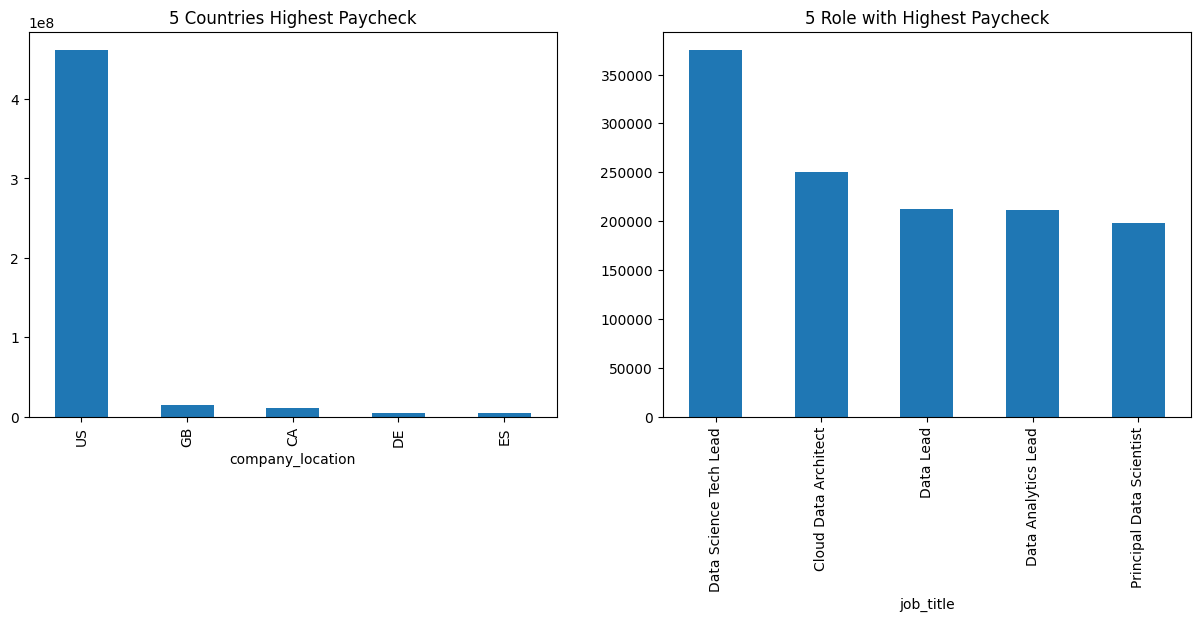

In [65]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
lar.plot(kind = "bar")
plt.title('5 Countries Highest Paycheck')

plt.subplot(1,2,2)
work.plot(kind = "bar")
plt.title('5 Role with Highest Paycheck')
plt.show()

negara dengan bayaran tertingi adalah United state, Great britian, Canada, Deutschland, dan Espanyol.
Jabatan dengan bayaran tertinggi adalh data science tech lead, cloud data architect, data lead, data analytics lead dan principal data scientist

## Most Job

In [66]:
# melihat job terbanyak
job = dup.groupby(['job_title'])['job_title'].count()
top_job = job.nlargest(10)
top_job

job_title
Data Engineer                1040
Data Scientist                840
Data Analyst                  612
Machine Learning Engineer     289
Analytics Engineer            103
Data Architect                101
Research Scientist             82
Applied Scientist              58
Data Science Manager           58
Research Engineer              37
Name: job_title, dtype: int64

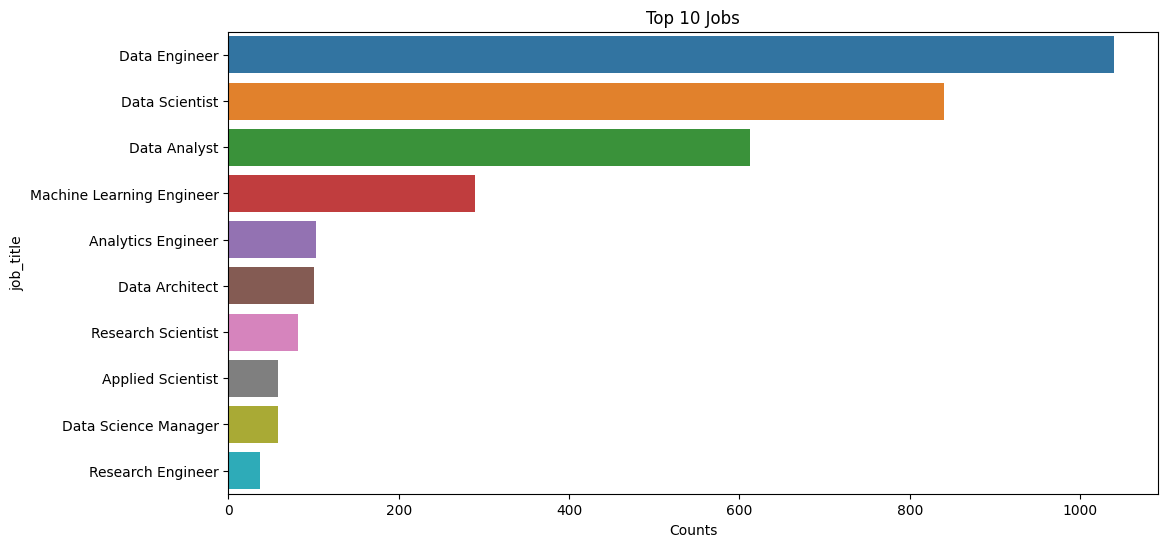

In [67]:
#plotting bar chart represent the count of each job title

plt.figure(figsize=(12,6))
plt.xticks(rotation=0)
plt.title("Top 10 Jobs")
plt.ylabel('Job Titles')
plt.xlabel('Counts')

sns.barplot(y=top_job.index, x= top_job.values);

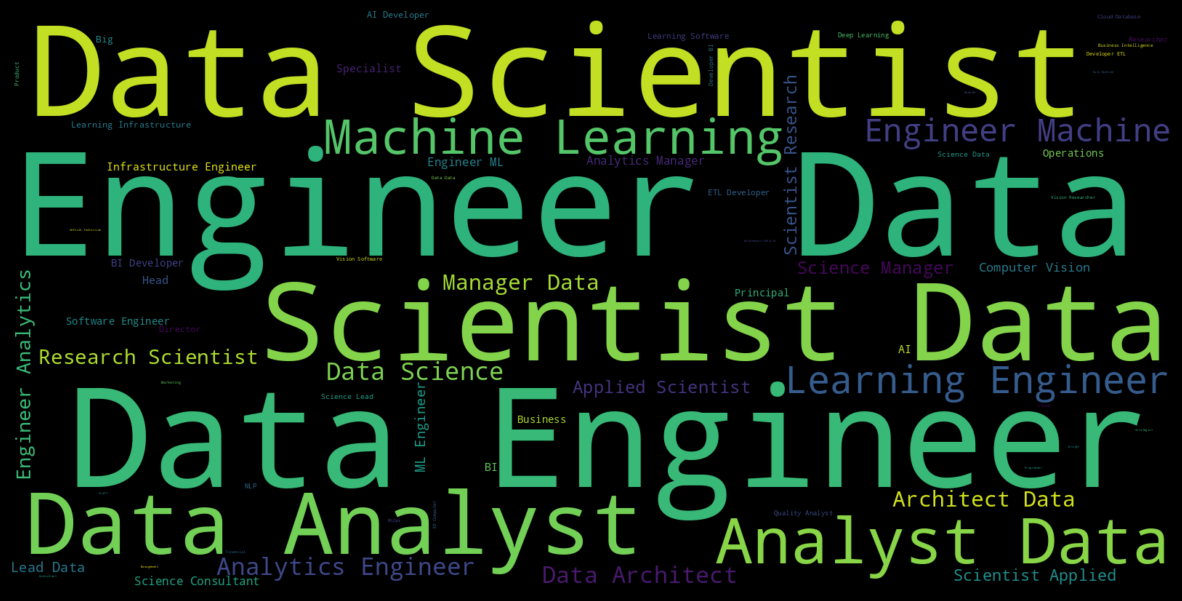

In [68]:
# see most job with word cloud
text = " ".join(i for i in dup.job_title)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1600, height=800).generate(text)
plt.figure( figsize=(15,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

berdasarkan visualisasi didapati bahwa pekerjaan terbanyak pada dataset ini adalah data engineer,data scientist dan data analyst ada juga banyak pekerjaan yang berhubungan dengan bidang data science yang dapat dilihat pada word cloud visualization seperti data architect dan lain lain.

## Company Size

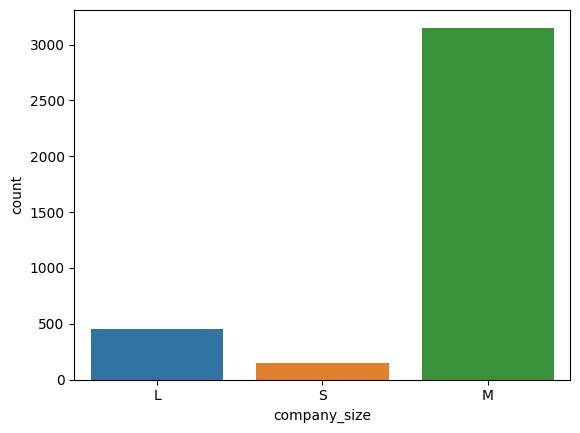

In [69]:
sns.countplot(data=dup, x="company_size")
plt.show()

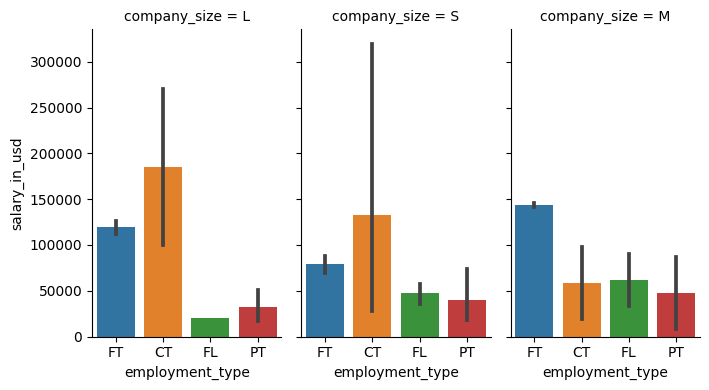

In [70]:
sns.catplot(
    data=dup, x="employment_type", y="salary_in_usd", col="company_size",
    kind="bar", height=4, aspect=.6,)

dari visualisasi diketahui bahwa pada dataset kali ini lebih banyak perusahaan pada skala middle. Pendistribusian gaji pada company size s dan l lebih besar pada karyawan kontrak sedangkan pada company size m lebih besar menggaji karyawan fulltime.

## Insight EDA

1. Experience Level terbanyak pada data adalah pada experince senior dan yang paling sedikit adalah pada level excecutive
2. Posisi FULLTIME (FT) memiliki gaji yang lebih besar pada semua experience level dibandingkan dengan tipe kerja lainnya. Namun pada level excecutive gaji terbesar dimiliki oleh karyawan kontrak.
3. Negara dengan bayaran tertingi adalah United state, Great britian, Canada, Deutschland, dan Espanyol. Jabatan dengan bayaran tertinggi adalh data science tech lead, cloud data architect, data lead, data analytics lead dan principal data scientist
4. Data Engineer, Data Scientist dan Data Analyst adalah 3 pekerjaan terpopuler dalam bidang data
5. Company size pada data didominasi oleh company middle size. Pegawai contract memiliki gaji yang lebih besar pada company size S dan L

# 5.Feature Engineering

## Split Feature(X) and Target (y)

kita tidak menggunakan kolom salary dan salary currency karena sudah diwakili oleh salary_in_usd

In [71]:
# spliting feature and target

X = df.drop(['salary','salary_currency','salary_in_usd'],axis=1) #feature
y= df['salary_in_usd'] #target
X

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,ES,100,ES,L
1,2023,MI,CT,ML Engineer,US,100,US,S
2,2023,MI,CT,ML Engineer,US,100,US,S
3,2023,SE,FT,Data Scientist,CA,100,CA,M
4,2023,SE,FT,Data Scientist,CA,100,CA,M
...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,US,100,US,L
3752,2020,EN,FT,Data Scientist,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,US,100,US,L


## Checking Multicollinearity

we dont need to check multicolinearity because the data that we have is categorical and not numerical

## Split Train and Test Set

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

print('X_Train Size :', X_train.shape)
print('X_Test Size :', X_test.shape)
X_train

X_Train Size : (3004, 8)
X_Test Size : (751, 8)


,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
2238,2022,SE,FT,Data Engineer,ES,0,ES,M
485,2023,MI,FT,Research Scientist,US,100,US,M
2177,2022,SE,FT,Data Analyst,US,0,US,M
3305,2022,SE,FT,Data Engineer,US,100,US,M
1769,2023,SE,FT,Data Engineer,US,100,US,M
...,...,...,...,...,...,...,...,...
1130,2023,SE,FT,Machine Learning Engineer,US,100,US,M
1294,2023,SE,FT,Data Analyst,US,0,US,M
860,2023,EX,FT,Data Engineer,US,100,US,M
3507,2021,MI,FT,Research Scientist,FR,50,FR,M


## Check Missing Values

In [73]:
X_train.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [74]:
X_test.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [75]:
y_train.isnull().sum()

0

In [76]:
y_test.isnull().sum()

0

## Checking Outliers

There will be no outlier because our data is a categorical data.

## Encoding

In [77]:
X_train.keys()

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size'],
      dtype='object')

In [78]:
# put into list
categorical_features = ['work_year', 'experience_level', 'employment_type', 'job_title',
       'employee_residence', 'remote_ratio', 'company_location','company_size']

In [79]:
# merubah fitur categorical menggunakan ordinalencoder
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1))
    ]
)

# Column Transformers
# pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)],
        remainder = 'passthrough'
)

# 6.Model Definition

Kita akan menggunakan algoritma regresi untuk menentukan salary, algoritma yang akan kita gunakan adalah:
- Linear Regression
- Linear Regression with Polynomial Regression
- Decision Tree Regression
- Random Forest Regression
- Gradient Boosting Regression

## Linear Regression

In [80]:
# Linear Regression Model

lr = Pipeline(
    steps=[("p", preprocessor), ("c", LinearRegression())]
)

## Linear Regression with Polynomial

In [81]:
# Linear Regression with Polynomial

poly = Pipeline(
    steps=[('p', preprocessor),('poly', PolynomialFeatures()), ('c',LinearRegression())]
)

## Decission Tree Regression

In [82]:
# Decission Tree Regression

dtr = Pipeline(
    steps=[('p', preprocessor),('c',DecisionTreeRegressor())]
)

## Random Forest Regression

In [83]:
# Random Forest Regression

rfr = Pipeline(
    steps=[('p', preprocessor),('c',RandomForestRegressor())]
)

## Gradient Boosting Regression

In [84]:
# Gradient Boosting Regression

gbr = Pipeline(
    steps=[('p', preprocessor),('c',GradientBoostingRegressor())]
)

# 7.Model Training

## Linear Regression

In [85]:
# Train linear regression
lr.fit(X_train, y_train)

Pipeline(steps=[('p',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(encoded_missing_value=-1,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['work_year',
                                                   'experience_level',
                                                   'employment_type',
                                                   'job_title',
                                                   'employee_residence',
                                                   'remote_ratio',
                                                   'company_location',
                                                   'company_size'])])),
                ('c', LinearRegression())])

## Polynomial

In [86]:
# Train poly regression
poly.fit(X_train, y_train)

Pipeline(steps=[('p',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(encoded_missing_value=-1,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['work_year',
                                                   'experience_level',
                                                   'employment_type',
                                                   'job_title',
                                                   'employee_residence',
                                                   'remote_ratio',
                                                   'company_location',
                                                   'company_size'])])),
                ('poly', PolynomialFeatures()), ('c', LinearRegression())])

## Decission Tree Regressor

In [87]:
# Train decission tree regression
dtr.fit(X_train, y_train)

Pipeline(steps=[('p',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(encoded_missing_value=-1,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['work_year',
                                                   'experience_level',
                                                   'employment_type',
                                                   'job_title',
                                                   'employee_residence',
                                                   'remote_ratio',
                                                   'company_location',
                                                   'company_size'])])),
                ('c', DecisionTreeRegressor())])

## Random Forest Regressor

In [88]:
# Train Random Forest regression
rfr.fit(X_train, y_train)

Pipeline(steps=[('p',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(encoded_missing_value=-1,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['work_year',
                                                   'experience_level',
                                                   'employment_type',
                                                   'job_title',
                                                   'employee_residence',
                                                   'remote_ratio',
                                                   'company_location',
                                                   'company_size'])])),
                ('c', RandomForestRegressor())])

## Gradient Boosting Regression

In [89]:
# Train decission tree regression
gbr.fit(X_train, y_train)

Pipeline(steps=[('p',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(encoded_missing_value=-1,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['work_year',
                                                   'experience_level',
                                                   'employment_type',
                                                   'job_title',
                                                   'employee_residence',
                                                   'remote_ratio',
                                                   'company_location',
                                                   'company_size'])])),
                ('c', GradientBoostingRegressor())])

# 8.Model Evaluation

## MAE

In [90]:
# Predict Train-set and Test-Set
# linear
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)
#poly
y_pred_train_poly = poly.predict(X_train)
y_pred_test_poly = poly.predict(X_test)
# decission tree
y_pred_train_dtr = dtr.predict(X_train)
y_pred_test_dtr = dtr.predict(X_test)
# random forest
y_pred_train_rfr = rfr.predict(X_train)
y_pred_test_rfr = rfr.predict(X_test)
# gradient boosting
y_pred_train_gbr = gbr.predict(X_train)
y_pred_test_gbr = gbr.predict(X_test)

# Model Evaluation Using MAE
#linnear
lat1 = mean_absolute_error(y_train, y_pred_train_lr)
tes1 = mean_absolute_error(y_test, y_pred_test_lr)
#poly
lat2 = mean_absolute_error(y_train, y_pred_train_poly)
tes2 = mean_absolute_error(y_test, y_pred_test_poly)
#decission tree
lat3 = mean_absolute_error(y_train, y_pred_train_dtr)
tes3 = mean_absolute_error(y_test, y_pred_test_dtr)
#random forest
lat4 = mean_absolute_error(y_train, y_pred_train_rfr)
tes4 = mean_absolute_error(y_test, y_pred_test_rfr)
#gradient boosting
lat5 = mean_absolute_error(y_train, y_pred_train_gbr)
tes5 = mean_absolute_error(y_test, y_pred_test_gbr)
print('Linear Regression')
print ('EROR - TRAIN SET MAE : ', lat1 )
print ('EROR - TEST SET MAE: ', tes1 )
print ('Difference', tes1-lat1)
print('Poly nomial')
print ('EROR - TRAIN SET MAE : ', lat2 )
print ('EROR - TEST SET MAE: ', tes2 )
print ('Difference', tes2-lat2)
print('Decission Tree')
print ('EROR - TRAIN SET MAE : ', lat3 )
print ('EROR - TEST SET MAE: ', tes3 )
print ('Difference', tes3-lat3)
print('Random Forest')
print ('EROR - TRAIN SET MAE : ', lat4 )
print ('EROR - TEST SET MAE: ', tes4 )
print ('Difference', tes4-lat4)
print('Gradient Boosting')
print ('EROR - TRAIN SET MAE : ', lat5 )
print ('EROR - TEST SET MAE: ', tes5 )
print ('Difference', tes5-lat5)

Linear Regression
EROR - TRAIN SET MAE :  41382.43939067977
EROR - TEST SET MAE:  41443.572093024595
Difference 61.13270234482479
Poly nomial
EROR - TRAIN SET MAE :  39790.30724741238
EROR - TEST SET MAE:  40675.301139910436
Difference 884.9938924980597
Decission Tree
EROR - TRAIN SET MAE :  27328.406831026718
EROR - TEST SET MAE:  40394.46456015288
Difference 13066.057729126165
Random Forest
EROR - TRAIN SET MAE :  29817.123917061443
EROR - TEST SET MAE:  37470.12596771656
Difference 7653.002050655115
Gradient Boosting
EROR - TRAIN SET MAE :  34483.63731397984
EROR - TEST SET MAE:  37820.088596241876
Difference 3336.451282262038


## Cross Validation

In [91]:
%%time
# Cross validate between model
models = []
models.append(('Linear Regression', lr))
models.append(('Polynomial', poly))
models.append(('Decission Tree Regressor', dtr))
models.append(('Random Forest Regressor', rfr))
models.append(('Gradient Boosting Regressor', gbr))

# Create variable to save the score
names = []
results = []
mean_score = []
std_score = []

# Find cross validation score each model
for name, model in models:
  model.fit(X_train, y_train)
  scores = cross_val_score(model, X_train, y_train, scoring='r2', n_jobs=-1)

  names.append(name)
  results.append(scores)
  mean_score.append(round(np.mean(scores), 3))
  std_score.append(round(np.std(scores), 3))

crossValResult = pd.DataFrame({'models':names, 'mean_score':mean_score, 'std_score':std_score})


CPU times: user 1 s, sys: 70.6 ms, total: 1.07 s
Wall time: 6.55 s


In [92]:
# Display score for each model
crossValResult.sort_values(by='mean_score', ascending=False)

,models,mean_score,std_score
4,Gradient Boosting Regressor,0.407,0.048
3,Random Forest Regressor,0.375,0.073
1,Polynomial,0.267,0.034
0,Linear Regression,0.248,0.051
2,Decission Tree Regressor,0.242,0.091


## Insight Model Evaluation

berdasarkan cross validation kita mendapatkan bahwa mean score tertinggi dari model adalah gradient boosting regressor dan random forest regressor. maka dari itu kita akan memilih ke dua model ini untuk dilakukan improvement.

# 9.Model Improvement

kita akan melakukan model improvement menggunakan gridsearchcv

## Parameters

In [93]:
# parameters GridSearch For gradient boosting
param_gb = {
    'c__n_estimators': [100, 200, 300],
    'c__learning_rate': [0.01, 0.1, 0.2],
    'c__max_depth': [3, 5, 7],
    'c__min_samples_split': [2, 5, 10]
}
# parameters GridSearch For random forest

param_rf = {
    'c__n_estimators': [100, 200, 300],
    'c__max_depth': [None, 5, 10, 20],
    'c__min_samples_split': [2, 5, 10],
    'c__max_features': ['auto', 'sqrt']
}

## Gradient Boosting Regressor

In [94]:
%%time
grid_search_gb = GridSearchCV(gbr, param_gb, cv=5, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

CPU times: user 3.35 s, sys: 335 ms, total: 3.69 s
Wall time: 2min 41s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('p',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder(encoded_missing_value=-1,
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['work_year',
                                                                          'experience_level',
                                                                          'employment_type',
                                                                          'job_title',
                                                                          'employee_residence',
                                                                          'remote_ratio',
                                                                          'company_location',
                                                                          'company_size'])])),
                                       ('c', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'c__learning_rate': [0.01, 0.1, 0.2],
                         'c__max_depth': [3, 5, 7],
                         'c__min_samples_split': [2, 5, 10],
                         'c__n_estimators': [100, 200, 300]})

In [95]:
print("Best cross-validation accuracy: {:.2f}".format(grid_search_gb.best_score_))
print("Test set score: {:.2f}".format(grid_search_gb.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search_gb.best_params_))

Best cross-validation accuracy: 0.41
Test set score: 0.40
Best parameters: {'c__learning_rate': 0.1, 'c__max_depth': 3, 'c__min_samples_split': 10, 'c__n_estimators': 100}


In [96]:
# save best model gradient boosting to variable
gbr_best_model = grid_search_gb.best_estimator_

## Random Forest Regressor

In [97]:
%%time
grid_search_rf = GridSearchCV(rfr, param_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

CPU times: user 4.13 s, sys: 367 ms, total: 4.5 s
Wall time: 3min 8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('p',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder(encoded_missing_value=-1,
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['work_year',
                                                                          'experience_level',
                                                                          'employment_type',
                                                                          'job_title',
                                                                          'employee_residence',
                                                                          'remote_ratio',
                                                                          'company_location',
                                                                          'company_size'])])),
                                       ('c', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'c__max_depth': [None, 5, 10, 20],
                         'c__max_features': ['auto', 'sqrt'],
                         'c__min_samples_split': [2, 5, 10],
                         'c__n_estimators': [100, 200, 300]})

In [98]:
print("Best cross-validation accuracy: {:.2f}".format(grid_search_rf.best_score_))
print("Test set score: {:.2f}".format(grid_search_rf.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search_rf.best_params_))

Best cross-validation accuracy: 0.41
Test set score: 0.41
Best parameters: {'c__max_depth': 10, 'c__max_features': 'sqrt', 'c__min_samples_split': 5, 'c__n_estimators': 300}


In [99]:
# save best model random forest to variable
rf_best_model = grid_search_rf.best_estimator_

## Model Evaluation

In [100]:
# Predict Train-set and Test-Set

# random forest with hyperparameter tuning
y_pred_train_rf_cv = rf_best_model.predict(X_train)
y_pred_test_rf_cv = rf_best_model.predict(X_test)

# gradient boosting with hyperparameter tuning
y_pred_train_gbr_cv = gbr_best_model.predict(X_train)
y_pred_test_gbr_cv = gbr_best_model.predict(X_test)

In [101]:
# Model Evaluation Using MAE

#random forest with hyperparameter tuning MAE
rf_mae_train = round(mean_absolute_error(y_train, y_pred_train_rf_cv),2)
rf_mae_test = round(mean_absolute_error(y_test, y_pred_test_rf_cv),2)

#gradient boosting with hyperparameter tuning MAE
gb_mae_train = round(mean_absolute_error(y_train, y_pred_train_gbr_cv),2)
gb_mae_test = round(mean_absolute_error(y_test, y_pred_test_gbr_cv),2)

In [102]:
print ('Random Forest')
print ('--'*20)
print ('MAE data train : ', rf_mae_train )
print ('MAE data test : ', rf_mae_test )
print ('--'*20)
print ('Random Forest Difference')
print ('MAE difference in test and train : ',rf_mae_test - rf_mae_train)
print ('--'*20)
print ('Gradient Boosting')
print ('--'*20)
print ('MAE data train : ', gb_mae_train )
print ('MAE data test : ', gb_mae_test  )
print ('--'*20)
print ('Gradient Boosting Difference')
print ('MAE difference in test and train : ',gb_mae_test - gb_mae_train)

Random Forest
----------------------------------------
MAE data train :  32815.56
MAE data test :  37036.26
----------------------------------------
Random Forest Difference
MAE difference in test and train :  4220.700000000004
----------------------------------------
Gradient Boosting
----------------------------------------
MAE data train :  34586.13
MAE data test :  37562.78
----------------------------------------
Gradient Boosting Difference
MAE difference in test and train :  2976.6500000000015


## Insight Model Improvement

dapat dilihat dari hasil metrics menggunakan MAE dilihat cukup besar hingga mencapai puluhan ribu, namun apakah benar ini nilai MAE yang besar? jika kita melihat dari describe data diketahui bahwa nilai salary_in_usd terkecil adalah 5132 dan yang terbesar adalah 450000. Sehingga bisa kita simpulkan bahwa nilai MAE disini merupakan nilai yang normal(Tidak terlalu besar dan tidak terlalu kecil).

kedua model ini bisa kita sebut **good fit** karena jarak antara train dan test tidak terlalu besar. berdasarkan MAE kita akan menggunakan model Gradient Boosting Regressor karena memiliki difference yang lebih kecil dari model random forest.

dalam melakukan proses modelling tentunya kita ingin mendapatkan nilai MAE yang lebih kecil. improvement yang dapat dilakukan adalah mencoba menambah banyaknya data, karena data yang digunakan dapat dibilang tidak terlalu banyak. Data yang lebih banyak dapat model menangkap lebih banyak pola untuk model belajar.

# 10.Model Saving

In [103]:
jb.dump(gbr_best_model, 'gradient_boosting_model.pkl')

['gradient_boosting_model.pkl']

# 11.Model Inference

bisa dicoba [disini](https://colab.research.google.com/drive/1dhUWUCS-30g_yFzj1g2Z1i1fAKB7XyJC?usp=sharing)

# 12.Kesimpulan

Kita telah berhasil membuat model untuk memprediksi gaji seseorang yang bekerja pada bidang data scientist. Model yang kita gunakan adalah model Gradient Boosting Regressor,terdapat eror pada model sebesar 37.567 yang menandakan gaji bisa lebih dari nilai prediksi sebesar 37.567  dan juga bisa kurang dari nilai prediksi sebesar 37.567(gaji perbulan akan meleset sekitar 3,130 $). Maka dari itu penggunaan model ini cocok untuk menentukan standar gaji dan bukan menjadi patokan khusus untuk menentukan gaji seorang data scientist.